In [1]:
import os
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from gensim.models import Word2Vec as wv

%load_ext autoreload
%matplotlib inline

module_path = os.path.abspath(os.path.join('./syn_ant_modules'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import model_dataset as dataset 
import model_functions_PhaseI as functions
import model_morphology as morpho
import model_testing_PhaseI as test 
import model_training_PhaseI as train

torch.manual_seed(28)

In [2]:
word_pairs_df = pd.read_excel('/Users/wesleytatum/Desktop/post_doc/BETO/BETO2020/Ant_Syn_Scraping/data/new_syn_ant_list.xlsx')
word_pairs_df = word_pairs_df.drop('Unnamed: 0', axis = 1)

ant_df = pd.read_csv('/Users/wesleytatum/Desktop/post_doc/data/wordnik_ant_df.csv')
word_pairs_df = word_pairs_df.append(ant_df, ignore_index = True)

In [3]:
word_pairs_df['label'].value_counts()

1    9535
2    5227
0    4699
Name: label, dtype: int64

In [4]:
#Vocabulary from Carbon corpus and Word2Vec model trained on all abstracts
#Opening contents of Word2Vec model1

w2v_model_path = '/Users/wesleytatum/Desktop/post_doc/data/w2v_models/200D_all_abstracts_model/full_corpus_w2v_mc5_s200_wdw10.model'
model1 = wv.load(w2v_model_path)
vocabulary1 = list(model1.wv.vocab)
print(f'w2v vocab length: {len(vocabulary1)}')

w2v_data_df = word_pairs_df.copy()

#finding which words are in the pd but not in vocabulary1
list1 = list(word_pairs_df['word 1'])
list2 = list(word_pairs_df['word 2'])
missing = list((set(list1).difference(vocabulary1))) + list((set(list2).difference(vocabulary1)))
print(f'number of word pair words: {len(list(set(list1+list2)))}')
print(f'number of missing words: {len(missing)}')

#keeping only the rows in the pd that have words in vocabulary1
w2v_data_df = w2v_data_df[~w2v_data_df['word 1'].isin(missing)]
w2v_data_df = w2v_data_df[~w2v_data_df['word 2'].isin(missing)]

#reseting indeces after mask
w2v_data_df.reset_index(inplace = True)

#creating list of individual words that are both in vocabulary1 and excel sheet 
#dict.fromkeys() ensuring there are no duplicates
common = list(set(list1)&set(vocabulary1))+list(set(list2)&set(vocabulary1))
common = list(dict.fromkeys(common))
common = sorted(common)
print(f'length of common vocab: {len(common)}')


w2v vocab length: 358151
number of word pair words: 13094
number of missing words: 3299
length of common vocab: 9795


In [5]:
#save vocab list and call it in the Pre_Trained_Embeddings
common_df = pd.DataFrame(common)
common_df.to_csv('./data/words_list.csv', index=False)


In [6]:
#for word pairs in our proposed training set, check if both words are in
#the common vocabulary list and then create a new dataframe with their indices

w2v_indx_df = pd.DataFrame(columns = ['word 1', 'word 2', 'label'])

pbar = tqdm(total = len(w2v_data_df), position = 0)

for i in range(len(w2v_data_df)):
    
    word1 = w2v_data_df['word 1'].iloc[i]
    word2 = w2v_data_df['word 2'].iloc[i]
    label = w2v_data_df['label'].iloc[i]
    
    if word1 in common:
        if word2 in common:
            index1 = common.index(word1)
            index2 = common.index(word2)
            w2v_indx_df.loc[i] = pd.Series({'word 1':index1, 'word 2':index2, 'label':label})
        else:
            pass
    else:
        pass
    pbar.update()

w2v_indx_df

100%|█████████▉| 14641/14666 [00:39<00:00, 290.84it/s]

,word 1,word 2,label
0,4806,1311,2
1,4806,1354,2
2,4806,1427,0
3,4806,1542,2
4,4806,3245,2
...,...,...,...
14661,4661,1721,2
14662,765,6682,2
14663,1057,4279,2
14664,1147,5509,2


100%|██████████| 14666/14666 [00:50<00:00, 290.84it/s]

In [13]:
w2v_indx_df.label.value_counts()

1    6631
2    4034
0    4001
Name: label, dtype: int64

In [7]:
X = w2v_indx_df[['word 1', 'word 2']]
Y = w2v_indx_df['label']

xtr, xts, ytr, yts = train_test_split(X, Y, test_size = 0.2, shuffle = True)

xtr_tens = torch.from_numpy(xtr.values.astype(float))
xts_tens = torch.from_numpy(xts.values.astype(float))
ytr_tens = torch.tensor(ytr.values.astype(float))
yts_tens = torch.tensor(yts.values.astype(float))

xtr_tens = xtr_tens.type(torch.long)
xts_tens = xts_tens.type(torch.long)
ytr_tens = ytr_tens.type(torch.long)
yts_tens = yts_tens.type(torch.long)

train_set = TensorDataset(xtr_tens, ytr_tens)
test_set = TensorDataset(xts_tens, yts_tens)

In [8]:
print(torch.unique(yts_tens))

tensor([0, 1, 2])


In [9]:
#Hyper parameters
num_epochs = 30
batch_size = 50
learning_rate = 5e-4

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_set, batch_size = batch_size, shuffle = True)

In [10]:
%autoreload

vocab_length = len(common)+1 #+1 avoids indexing error
print(f'vocabulary length = {vocab_length}')

# Instantiate NN model. 'in_dims' = dimensions of embeddings in 'common'
model = morpho.Phase_I_NN(in_dims = 200,
                          vocab_length = vocab_length,
                          common = common,
                          w2v_model = model1).to(device)
model.apply(functions.init_weights)

#define the optimizer
optimizer = torch.optim.AdamW(params = model.parameters(),
                              lr = learning_rate,
                              amsgrad = True)

vocabulary length = 9796


In [11]:
%autoreload

#empty list to hold loss per epoch
train_epoch_losses = []
syn_train_epoch_losses = []
ant_train_epoch_losses = []
syn_train_epoch_accuracies = []
ant_train_epoch_accuracies = []
irrel_train_epoch_accuracies = []
train_p2_syn_accs = []
train_p2_ant_accs = []
train_p2_irrel_accs = []

test_epoch_losses = []
syn_test_epoch_losses = []
ant_test_epoch_losses = []
syn_test_epoch_accuracies = []
ant_test_epoch_accuracies = []
irrel_test_epoch_accuracies = []
test_p2_syn_accs = []
test_p2_ant_accs = []
test_p2_irrel_accs = []

pbar = tqdm(total = num_epochs, position = 0)

for epoch in range(num_epochs):
    
    train_epoch_loss, syn_train_epoch_loss, ant_train_epoch_loss, Lm_train_epoch_loss, train_syn_epoch_acc, train_ant_epoch_acc, train_irrel_epoch_acc, train_p2_accs = train.Phase_I_train_model(model = model, training_data_set = train_loader, optimizer = optimizer)
        
    train_epoch_losses.append(train_epoch_loss)
    syn_train_epoch_losses.append(syn_train_epoch_loss)
    ant_train_epoch_losses.append(ant_train_epoch_loss)
    syn_train_epoch_accuracies.append(train_syn_epoch_acc)
    ant_train_epoch_accuracies.append(train_ant_epoch_acc)
    irrel_train_epoch_accuracies.append(train_irrel_epoch_acc)
    train_p2_irrel_accs.append(train_p2_accs[0])
    train_p2_syn_accs.append(train_p2_accs[1])
    train_p2_ant_accs.append(train_p2_accs[2])
       
    test_epoch_loss, syn_test_epoch_loss, ant_test_epoch_loss, Lm_test_epoch_loss, syn_epoch_acc, ant_epoch_acc, irrel_epoch_acc, syn_true, syn_predictions, ant_true, ant_predictions, test_p2_accs = test.Phase_I_eval_model(model = model, testing_data_set = test_loader, optimizer = optimizer)
        
    test_epoch_losses.append(test_epoch_loss)
    syn_test_epoch_losses.append(syn_test_epoch_loss)
    ant_test_epoch_losses.append(ant_test_epoch_loss)
    syn_test_epoch_accuracies.append(syn_epoch_acc)
    ant_test_epoch_accuracies.append(ant_epoch_acc)
    irrel_test_epoch_accuracies.append(irrel_epoch_acc)
    test_p2_irrel_accs.append(test_p2_accs[0])
    test_p2_syn_accs.append(test_p2_accs[1])
    test_p2_ant_accs.append(test_p2_accs[2])

    pbar.update()

  0%|          | 0/30 [00:00<?, ?it/s]

[0]	eval-merror:0.54112	train-merror:0.47533
[1]	eval-merror:0.53473	train-merror:0.45786
[2]	eval-merror:0.53728	train-merror:0.45061
[3]	eval-merror:0.53856	train-merror:0.44539
[4]	eval-merror:0.53558	train-merror:0.43868


  3%|▎         | 1/30 [00:15<07:18, 15.14s/it]

[0]	eval-merror:0.51470	train-merror:0.47864
[1]	eval-merror:0.50405	train-merror:0.46052
[2]	eval-merror:0.50405	train-merror:0.44592
[3]	eval-merror:0.50021	train-merror:0.44230
[4]	eval-merror:0.50234	train-merror:0.43932


  7%|▋         | 2/30 [00:31<07:10, 15.37s/it]

[0]	eval-merror:0.48317	train-merror:0.46489
[1]	eval-merror:0.49212	train-merror:0.45434
[2]	eval-merror:0.49297	train-merror:0.44816
[3]	eval-merror:0.49467	train-merror:0.44305
[4]	eval-merror:0.49382	train-merror:0.43974


 10%|█         | 3/30 [00:48<07:08, 15.88s/it]

[0]	eval-merror:0.47209	train-merror:0.44550
[1]	eval-merror:0.47678	train-merror:0.44198
[2]	eval-merror:0.48147	train-merror:0.43633
[3]	eval-merror:0.47806	train-merror:0.42472
[4]	eval-merror:0.47806	train-merror:0.42110


 13%|█▎        | 4/30 [01:04<06:55, 15.97s/it]

[0]	eval-merror:0.47635	train-merror:0.43271
[1]	eval-merror:0.47294	train-merror:0.42312
[2]	eval-merror:0.47422	train-merror:0.41790
[3]	eval-merror:0.47465	train-merror:0.41396
[4]	eval-merror:0.46954	train-merror:0.40533


 17%|█▋        | 5/30 [01:21<06:47, 16.29s/it]

[0]	eval-merror:0.44695	train-merror:0.42152
[1]	eval-merror:0.45036	train-merror:0.41374
[2]	eval-merror:0.45420	train-merror:0.40980
[3]	eval-merror:0.45462	train-merror:0.40565
[4]	eval-merror:0.45207	train-merror:0.39957


 20%|██        | 6/30 [01:37<06:32, 16.34s/it]

[0]	eval-merror:0.44397	train-merror:0.41108
[1]	eval-merror:0.44227	train-merror:0.40703
[2]	eval-merror:0.44525	train-merror:0.40107
[3]	eval-merror:0.44738	train-merror:0.39542
[4]	eval-merror:0.44440	train-merror:0.39073


 23%|██▎       | 7/30 [01:55<06:23, 16.69s/it]

[0]	eval-merror:0.43971	train-merror:0.41034
[1]	eval-merror:0.43758	train-merror:0.40447
[2]	eval-merror:0.43673	train-merror:0.39979
[3]	eval-merror:0.44312	train-merror:0.39371
[4]	eval-merror:0.44099	train-merror:0.39030


 27%|██▋       | 8/30 [02:13<06:17, 17.17s/it]

[0]	eval-merror:0.45249	train-merror:0.40160
[1]	eval-merror:0.44994	train-merror:0.39361
[2]	eval-merror:0.44397	train-merror:0.38839
[3]	eval-merror:0.45164	train-merror:0.38306
[4]	eval-merror:0.44567	train-merror:0.38039


 30%|███       | 9/30 [02:30<05:59, 17.13s/it]

[0]	eval-merror:0.42011	train-merror:0.39382
[1]	eval-merror:0.41841	train-merror:0.38785
[2]	eval-merror:0.41968	train-merror:0.38221
[3]	eval-merror:0.41628	train-merror:0.37837
[4]	eval-merror:0.41329	train-merror:0.37453


 33%|███▎      | 10/30 [02:50<05:58, 17.92s/it]

[0]	eval-merror:0.43460	train-merror:0.40224
[1]	eval-merror:0.43289	train-merror:0.39137
[2]	eval-merror:0.43119	train-merror:0.38466
[3]	eval-merror:0.42906	train-merror:0.38114
[4]	eval-merror:0.43076	train-merror:0.37933


 37%|███▋      | 11/30 [03:07<05:35, 17.66s/it]

[0]	eval-merror:0.42991	train-merror:0.39659
[1]	eval-merror:0.41841	train-merror:0.38966
[2]	eval-merror:0.41841	train-merror:0.38487
[3]	eval-merror:0.41968	train-merror:0.37730
[4]	eval-merror:0.42352	train-merror:0.37038


 40%|████      | 12/30 [03:24<05:13, 17.41s/it]

[0]	eval-merror:0.41968	train-merror:0.39084
[1]	eval-merror:0.41031	train-merror:0.38380
[2]	eval-merror:0.40775	train-merror:0.37997
[3]	eval-merror:0.41031	train-merror:0.37496
[4]	eval-merror:0.40988	train-merror:0.36846


 43%|████▎     | 13/30 [03:39<04:44, 16.74s/it]

[0]	eval-merror:0.41542	train-merror:0.38476
[1]	eval-merror:0.41755	train-merror:0.38274
[2]	eval-merror:0.41883	train-merror:0.37571
[3]	eval-merror:0.41713	train-merror:0.37304
[4]	eval-merror:0.41841	train-merror:0.37017


 47%|████▋     | 14/30 [03:54<04:19, 16.21s/it]

[0]	eval-merror:0.43247	train-merror:0.38519
[1]	eval-merror:0.43119	train-merror:0.37603
[2]	eval-merror:0.43417	train-merror:0.37123
[3]	eval-merror:0.42650	train-merror:0.36644
[4]	eval-merror:0.42437	train-merror:0.36601


 50%|█████     | 15/30 [04:09<03:58, 15.91s/it]

[0]	eval-merror:0.42693	train-merror:0.38753
[1]	eval-merror:0.42181	train-merror:0.38306
[2]	eval-merror:0.41841	train-merror:0.37965
[3]	eval-merror:0.42181	train-merror:0.37368
[4]	eval-merror:0.42224	train-merror:0.37176


 53%|█████▎    | 16/30 [04:24<03:38, 15.63s/it]

[0]	eval-merror:0.42096	train-merror:0.38775
[1]	eval-merror:0.42267	train-merror:0.38189
[2]	eval-merror:0.41755	train-merror:0.37848
[3]	eval-merror:0.41372	train-merror:0.37059
[4]	eval-merror:0.41841	train-merror:0.36654


 57%|█████▋    | 17/30 [04:40<03:23, 15.65s/it]

[0]	eval-merror:0.42054	train-merror:0.38476
[1]	eval-merror:0.42522	train-merror:0.37826
[2]	eval-merror:0.42522	train-merror:0.37357
[3]	eval-merror:0.42352	train-merror:0.36846
[4]	eval-merror:0.41968	train-merror:0.36409


 60%|██████    | 18/30 [04:56<03:08, 15.68s/it]

[0]	eval-merror:0.41287	train-merror:0.38402
[1]	eval-merror:0.41074	train-merror:0.37592
[2]	eval-merror:0.40988	train-merror:0.37187
[3]	eval-merror:0.41031	train-merror:0.36857
[4]	eval-merror:0.40775	train-merror:0.36420


 63%|██████▎   | 19/30 [05:11<02:50, 15.50s/it]

[0]	eval-merror:0.41883	train-merror:0.38093
[1]	eval-merror:0.41287	train-merror:0.37688
[2]	eval-merror:0.41841	train-merror:0.37219
[3]	eval-merror:0.41670	train-merror:0.36921
[4]	eval-merror:0.41926	train-merror:0.36345


 67%|██████▋   | 20/30 [05:26<02:33, 15.34s/it]

[0]	eval-merror:0.39881	train-merror:0.38157
[1]	eval-merror:0.39156	train-merror:0.37688
[2]	eval-merror:0.39497	train-merror:0.37017
[3]	eval-merror:0.40094	train-merror:0.36612
[4]	eval-merror:0.39923	train-merror:0.36143


 70%|███████   | 21/30 [05:41<02:18, 15.34s/it]

[0]	eval-merror:0.42991	train-merror:0.38370
[1]	eval-merror:0.42395	train-merror:0.37453
[2]	eval-merror:0.42054	train-merror:0.36846
[3]	eval-merror:0.41670	train-merror:0.36462
[4]	eval-merror:0.41372	train-merror:0.36143


 73%|███████▎  | 22/30 [05:57<02:03, 15.45s/it]

[0]	eval-merror:0.40861	train-merror:0.37624
[1]	eval-merror:0.41031	train-merror:0.37144
[2]	eval-merror:0.40605	train-merror:0.36462
[3]	eval-merror:0.41415	train-merror:0.36281
[4]	eval-merror:0.41883	train-merror:0.35685


 77%|███████▋  | 23/30 [06:12<01:47, 15.38s/it]

[0]	eval-merror:0.41841	train-merror:0.38626
[1]	eval-merror:0.41329	train-merror:0.37901
[2]	eval-merror:0.40988	train-merror:0.37208
[3]	eval-merror:0.41329	train-merror:0.36644
[4]	eval-merror:0.41755	train-merror:0.36217


 80%|████████  | 24/30 [06:27<01:31, 15.29s/it]

[0]	eval-merror:0.40903	train-merror:0.37581
[1]	eval-merror:0.41116	train-merror:0.37198
[2]	eval-merror:0.40222	train-merror:0.36718
[3]	eval-merror:0.40477	train-merror:0.36207
[4]	eval-merror:0.40733	train-merror:0.35546


 83%|████████▎ | 25/30 [06:43<01:17, 15.56s/it]

[0]	eval-merror:0.41500	train-merror:0.37528
[1]	eval-merror:0.41713	train-merror:0.36899
[2]	eval-merror:0.41202	train-merror:0.36644
[3]	eval-merror:0.40690	train-merror:0.36217
[4]	eval-merror:0.40861	train-merror:0.35983


 87%|████████▋ | 26/30 [06:58<01:01, 15.43s/it]

[0]	eval-merror:0.39625	train-merror:0.37411
[1]	eval-merror:0.38943	train-merror:0.36899
[2]	eval-merror:0.39284	train-merror:0.36484
[3]	eval-merror:0.39242	train-merror:0.36569
[4]	eval-merror:0.39412	train-merror:0.35972


 90%|█████████ | 27/30 [07:14<00:46, 15.38s/it]

[0]	eval-merror:0.41628	train-merror:0.38455
[1]	eval-merror:0.40775	train-merror:0.37613
[2]	eval-merror:0.40733	train-merror:0.37091
[3]	eval-merror:0.40562	train-merror:0.36612
[4]	eval-merror:0.40733	train-merror:0.36249


 93%|█████████▎| 28/30 [07:29<00:30, 15.39s/it]

[0]	eval-merror:0.41500	train-merror:0.38295
[1]	eval-merror:0.40988	train-merror:0.37581
[2]	eval-merror:0.41074	train-merror:0.36867
[3]	eval-merror:0.41031	train-merror:0.36473
[4]	eval-merror:0.40903	train-merror:0.36281


 97%|█████████▋| 29/30 [07:44<00:15, 15.33s/it]

[0]	eval-merror:0.41415	train-merror:0.37357
[1]	eval-merror:0.40648	train-merror:0.36612
[2]	eval-merror:0.40392	train-merror:0.36068
[3]	eval-merror:0.40648	train-merror:0.35813
[4]	eval-merror:0.40690	train-merror:0.35312


100%|██████████| 30/30 [07:59<00:00, 15.31s/it]

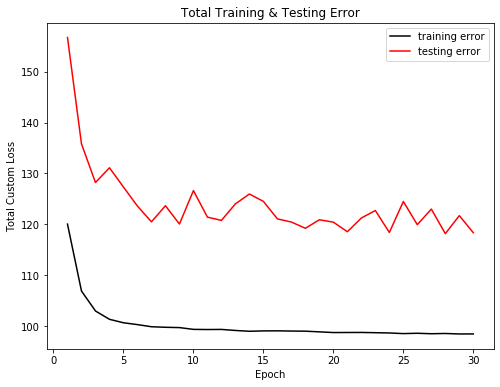

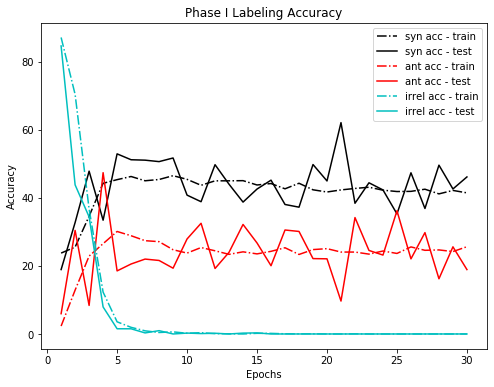

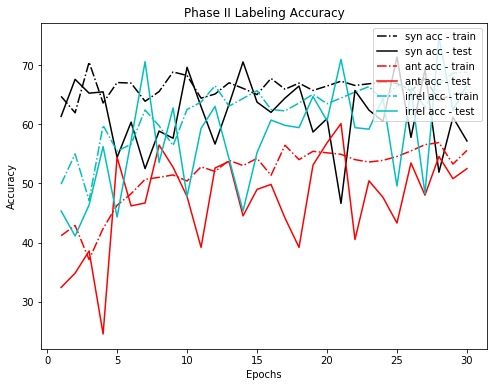

In [12]:
fig, ax = plt.subplots(figsize = (8,6))

epochs = np.arange(1, (num_epochs+1), 1)

plt.plot(epochs, train_epoch_losses, c = 'k', label = 'training error')
plt.plot(epochs, test_epoch_losses, c = 'r', label = 'testing error')
plt.legend(loc = 'upper right')
plt.title("Total Training & Testing Error")
ax.set_xlabel('Epoch')
ax.set_ylabel('Total Custom Loss')
plt.show()

fig, ax = plt.subplots(figsize = (8,6))
plt.plot(epochs, syn_train_epoch_accuracies, c = 'k', linestyle = '-.', label = 'syn acc - train')
plt.plot(epochs, syn_test_epoch_accuracies, c = 'k', label = 'syn acc - test')
plt.plot(epochs, ant_train_epoch_accuracies, c = 'r', linestyle = '-.', label = 'ant acc - train')
plt.plot(epochs, ant_test_epoch_accuracies, c = 'r', label = 'ant acc - test')
plt.plot(epochs, irrel_train_epoch_accuracies, c = 'c', linestyle = '-.', label = 'irrel acc - train')
plt.plot(epochs, irrel_test_epoch_accuracies, c = 'c', label = 'irrel acc - test')
plt.legend(loc = 'upper right')
plt.title("Phase I Labeling Accuracy")
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.show()

fig, ax = plt.subplots(figsize = (8,6))
plt.plot(epochs, train_p2_syn_accs, c = 'k', linestyle = '-.', label = 'syn acc - train')
plt.plot(epochs, test_p2_syn_accs, c = 'k', label = 'syn acc - test')
plt.plot(epochs, train_p2_ant_accs, c = 'r', linestyle = '-.', label = 'ant acc - train')
plt.plot(epochs, test_p2_ant_accs, c = 'r', label = 'ant acc - test')
plt.plot(epochs, train_p2_irrel_accs, c = 'c', linestyle = '-.', label = 'irrel acc - train')
plt.plot(epochs, test_p2_irrel_accs, c = 'c', label = 'irrel acc - test')
plt.legend(loc = 'upper right')
plt.title("Phase II Labeling Accuracy")
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.show()

In [ ]:
#thresholding the predicted values to be compared to the labels
syn_predictions = list(map(lambda x:1 if x >= 0.8 else x, syn_predictions))
syn_predictions = list(map(lambda x:0 if -0.8 < x < 0.8 else x, syn_predictions))
syn_predictions = list(map(lambda x:-1 if x <= -0.8 else x, syn_predictions))

ant_predictions = list(map(lambda x:1 if x >= 0.8 else x, ant_predictions))
ant_predictions = list(map(lambda x:0 if -0.8 < x < 0.8 else x, ant_predictions))
ant_predictions = list(map(lambda x:-1 if x <= -0.8 else x, ant_predictions))


#synonymy confusion matrix
syn_matrix = confusion_matrix(syn_true, syn_predictions)

#antonymy confusion matrix
ant_matrix = confusion_matrix(ant_true, ant_predictions)

In [ ]:
syn_matrix

In [ ]:
ant_matrix